In [1]:
import pandas as pd

file = 'model/efficient_labelled_1.0_0511151159/csv_logs/lightning_logs/version_0/metrics.csv'
df = pd.read_csv(file)

In [2]:
df.columns

Index(['epoch', 'step', 'train_acc_epoch', 'train_acc_step',
       'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_loss'],
      dtype='object')

We can observe the evolution of the training accuracy by epoch, as the model learns the data.

In [3]:
# evolution of train_acc_epoch by epochs 
df.iloc[df['train_acc_epoch'].dropna().index][['train_loss_epoch', 'train_acc_epoch']]

,train_loss_epoch,train_acc_epoch
541,2.588709,0.434178
1084,1.818211,0.589161
1627,1.542749,0.644817
2169,1.354655,0.683149
2712,1.206732,0.714430
3255,1.094926,0.737706
3797,0.798222,0.805320
4340,0.682118,0.830272


However, alidation accuracy does not increase at a similar, showing that the model is overfitting.

In [4]:
df[['val_acc', 'val_loss']].dropna()

,val_acc,val_loss
540,0.434374,2.694858
1083,0.384066,2.954183
1626,0.481793,2.478314
2168,0.444686,2.756868
2711,0.474603,2.570438
3254,0.490440,2.517863
3796,0.510762,2.555993
4339,0.475782,2.813143


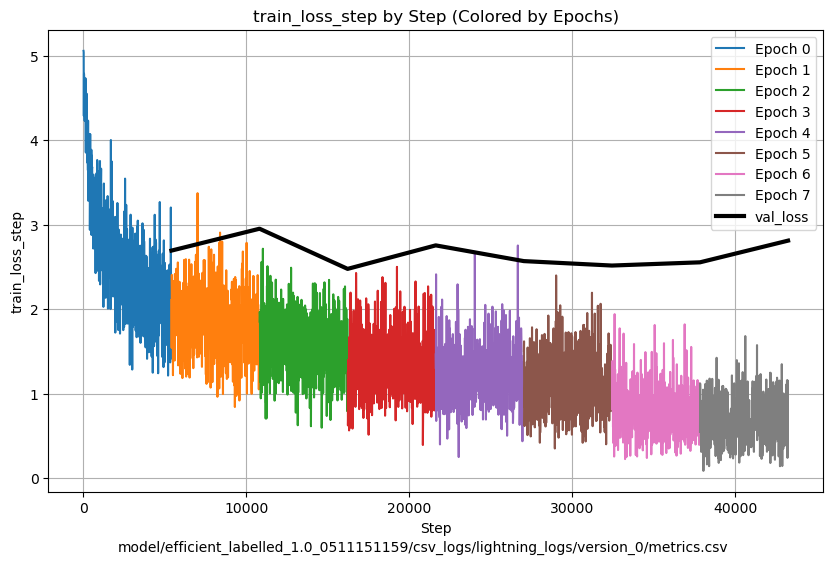

In [5]:
import matplotlib.pyplot as plt

def plot_column_evolution(df: pd.DataFrame, col: str, col_val:str, footer_note: str = ''):
    plt.figure(figsize=(10, 6))

    for epoch in df['epoch'].unique():
        subset = df[df['epoch'] == epoch]
        plt.plot(subset['step'], subset[col], label=f'Epoch {epoch}')

    plt.xlabel('Step')
    plt.ylabel(col)
    plt.title(f'{col} by Step (Colored by Epochs)')
    plt.grid(True)
    
    if footer_note:
        plt.figtext(0.5, 0.01, footer_note, wrap=True, horizontalalignment='center', fontsize=10)

    clean_df = df[['step', col_val]].dropna()
    plt.plot(clean_df['step'], clean_df[col_val], color='black', linewidth=3, label=col_val)

    plt.legend()
    plt.show()

plot_column_evolution(df, 'train_loss_step', 'val_loss', file)

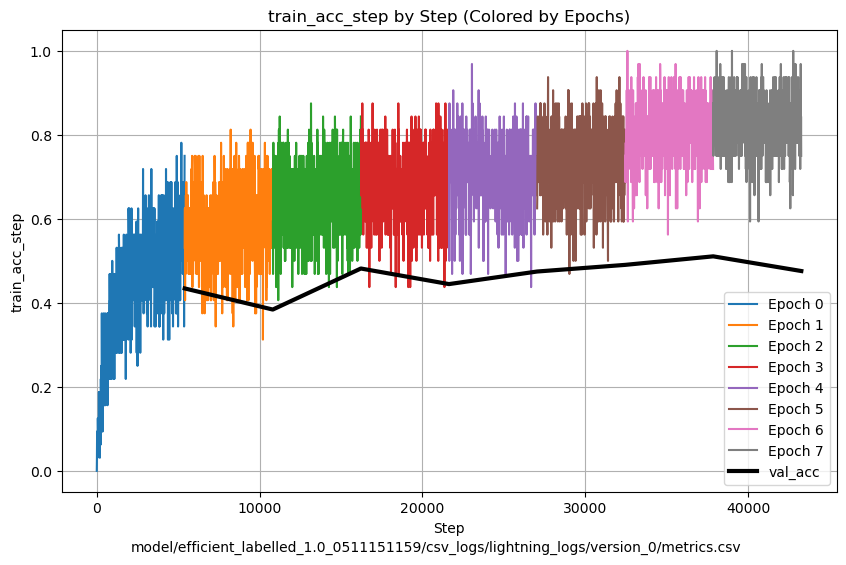

In [6]:
plot_column_evolution(df, 'train_acc_step', 'val_acc', file)